In [2]:
# notebook has to be at the very top, then we switch back to inline
%matplotlib notebook  
%matplotlib inline

In [4]:
import pandas as pd 
import sys
#import torch
#import torch.nn as nn
#from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
#from livelossplot import PlotLosses
#import time 
import numpy as np
sys.path.append('../..//duq/')
  
# Importing the Bayesian LR module
import pre, post
#import post, pre
import mc_dropout as MC

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses sklearn warning about PCA.. Is this ok?

Device =  cpu


In [5]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

# Importing Data

## Import Full Dataset

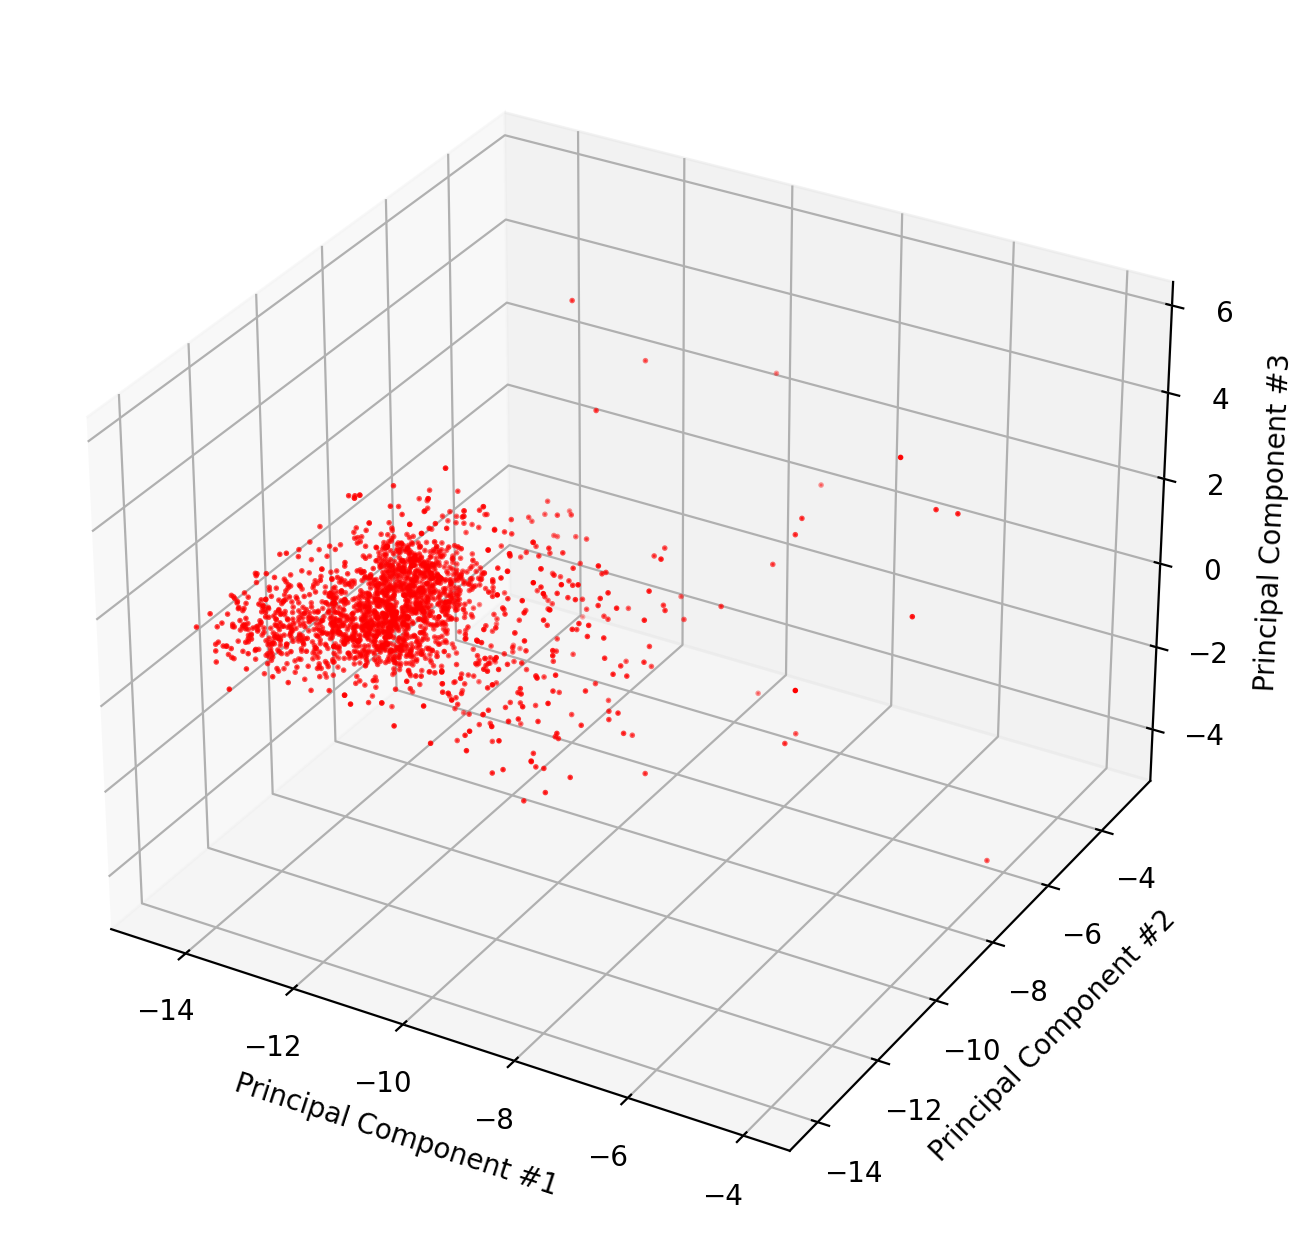

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [13]:
# num_x, num_y, num_z, width_x, width_y, width_z, freq1, freq2, freq3, freq4, freq5, freq6, L2 dist
# [0]    [1]    [2]    [3]      [4]      [5]      [6]    [7]    [8]    [9]    [10]   [11]   [12]

y_cols = [6]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"
# Import the csv file and save as DataFrame
## DATASET 1 ###
filepath = '../../data/all_data.csv' 
#filepath = '../data/GSA_1000_datapoints_6freq.csv' # [[3, 10], [3, 10], [3, 10], [5, 10], [5, 10], [5, 10]]  1000no
#filepath = '../data/extreme_30.csv'   # [[1, 30], [1, 30], [1, 50], [0.5, 25], [0.5, 25], [0.5, 25]]  30no
#filepath = '../data/moderate_50.csv'  # [[1, 15], [1, 15], [1, 15], [0.5, 15], [0.5, 15], [0.5, 15]]  50no 
#filepath = '../data/moderate_400.csv'  # [[1, 15], [1, 15], [1, 30], [0.5, 15], [0.5, 15], [0.5, 15]]  400no 
#filepath = '../data/narrowish_300.csv' # [[1, 10], [1, 10], [1, 10], [0.5, 10], [0.5, 10], [0.5, 10]]  300no
#filepath = '../data/slim_200.csv' # [[1, 5], [1, 5], [1, 5], [0.5, 10], [0.5, 10], [0.5, 10]]  200no

df_orig = pd.read_csv(filepath)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

data_mean = df_orig.mean()
data_std = df_orig.std()

# Get PCA components based on UNNORMALISED data
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

# Get PCA transform of NORMALISED data
df_orig_norm = pre.normalise(df_orig, data_mean, data_std)
all_PCA_norm = post.PCA_transformdata(df_orig_norm.iloc[:,x_cols], components=components)
post.PCA_plot(all_PCA_norm, figsize=(8,8), legend=False,dpi=200)

In [14]:
# Define the wandb parameters
parameters = dict(
    # Specific to this method
    drop_prob= 0.2,              # Probablity that a neuron will be switched off
    num_samples=150,              # How many forward passes of the network to make to construct the posterior distribution
    
    # Generic Hyperparameters
    num_epochs= 500,
    batch_size= 50, # Batch size for training data
    lr=  5e-4,                   # Learning rate
    weight_decay= 0.001,          # Weight decay. 
    
    # Model architecture
    input_dim= len(x_cols),                # Number of input neurons
    output_dim= len(y_cols),               # Number of output neurons
    num_units= 10,              # Number of neurons per hidden layer
    num_layers=3,
    
    # Data
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    
    # Logging only
    component = None,       # Which parameter are we sorting by (as an int)? 
    sortby=None,       # Name of the component we're sorting by (as a string)
    model_name= "MC_Dropout",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only
    cutoff_percentile = None,  # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=None,         # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed                   # Random seed used (for logging only)
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

## Split Data by L2 Dist from Geometric Mean

len(x_train): 1182
len(x_test): 692
len(x_val): 132


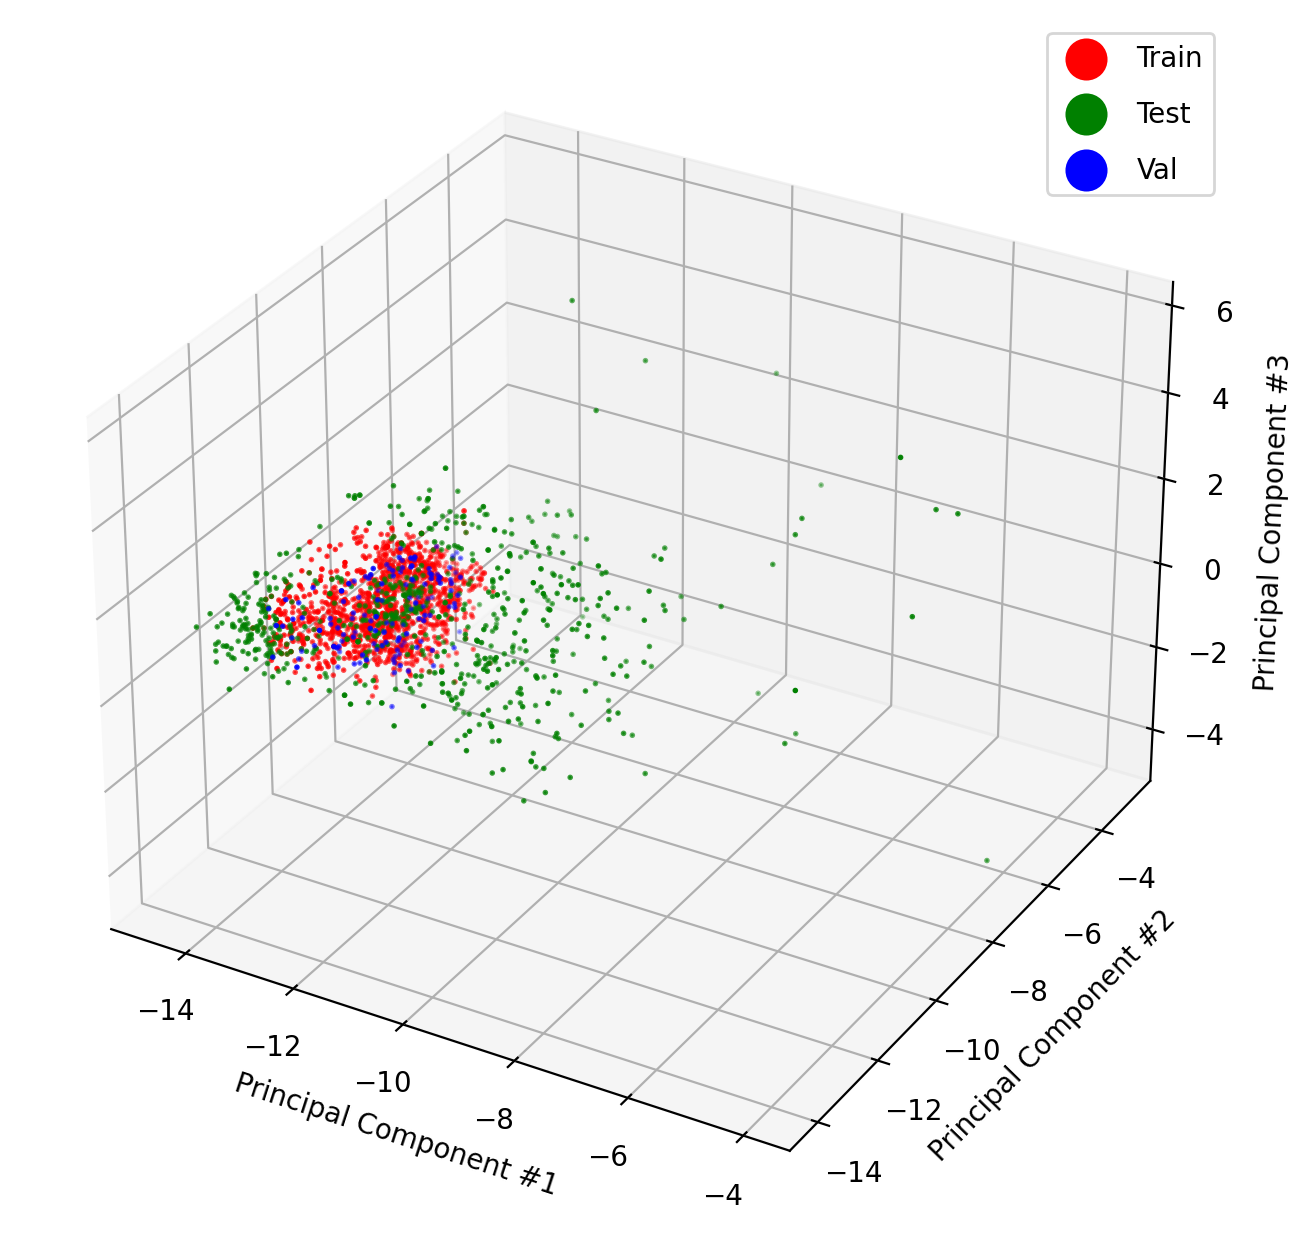

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [16]:
# Add a new column for L2 distance from Eulicidean mean and normalise. Return the original mean and sigma
df_1, data_mean_1, data_std_1 = pre.process_df_euclid(df=df_orig.copy(), x_cols=x_cols)

component = 12           # Which column to sort by? This affects the splitting of validation data and visualisation later on
cutoff_percentile = (0.05,0.3)#0.2775 # How much to cut off the beginning and end of sorted dataset
val_split = 0.1          # How much to split off for validation (after the OoD/test data has been split off from train)

# Split training, testing and validation data
TRAIN, VAL, TEST = pre.split_data(df_1, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

print(f"len(x_train): {len(x_train)}")
print(f"len(x_test): {len(x_test)}")
print(f"len(x_val): {len(x_val)}")

# Get PCA of NORMALISED data, but according to UNNORMALISED PCA components
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], labels=["Train", "Test", "Val"], legend_num=0, figsize=(8,8),dpi=200)

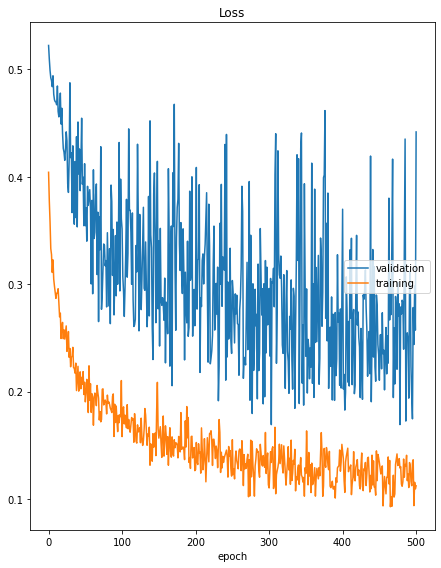

Loss
	validation       	 (min:    0.169, max:    0.522, cur:    0.442)
	training         	 (min:    0.093, max:    0.404, cur:    0.112)
Time elapsed: 13.69s.
Number of trainable model parameters: 191, number of training samples: 1182
Used batches of 50.



TypeError: distplot() got an unexpected keyword argument 'dpi'

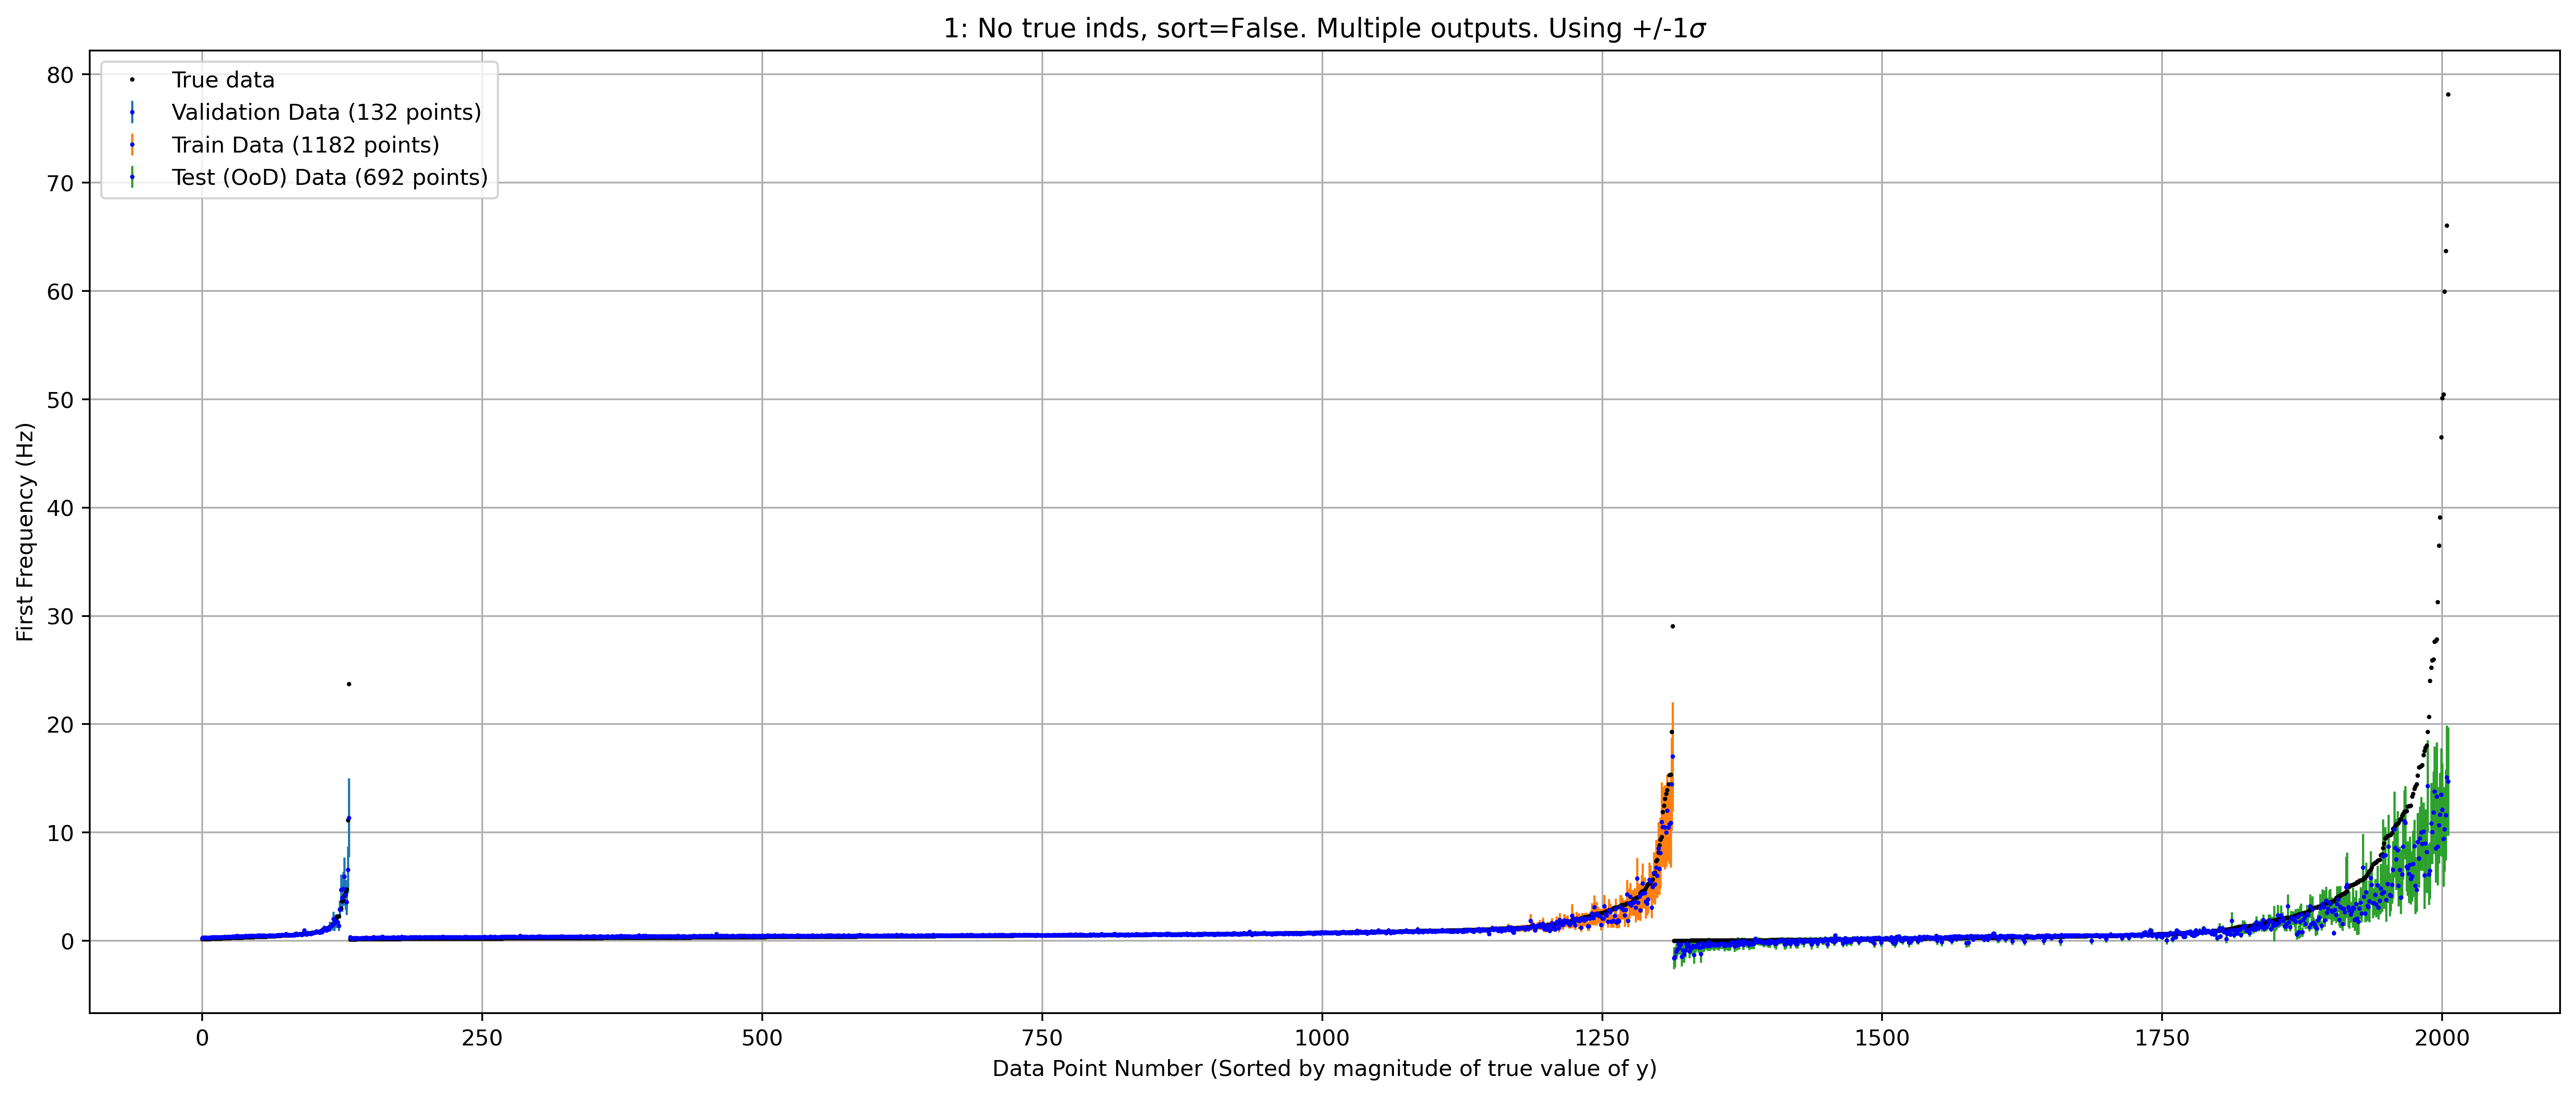

In [17]:
model = MC.MC_Dropout(train_data = train_data,
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      parameters=parameters)
net, train_loss, val_loss = model.train_model(LLP=True)
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = "n/a",
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)")
             #ylim=(0,1.5))
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3, bins=100, figsize=(17,20))

## Split Data by L2 Dist from Arbitrary Point

len(x_train): 1220
len(x_test): 633
len(x_val): 136
Total: 1989 of 1977


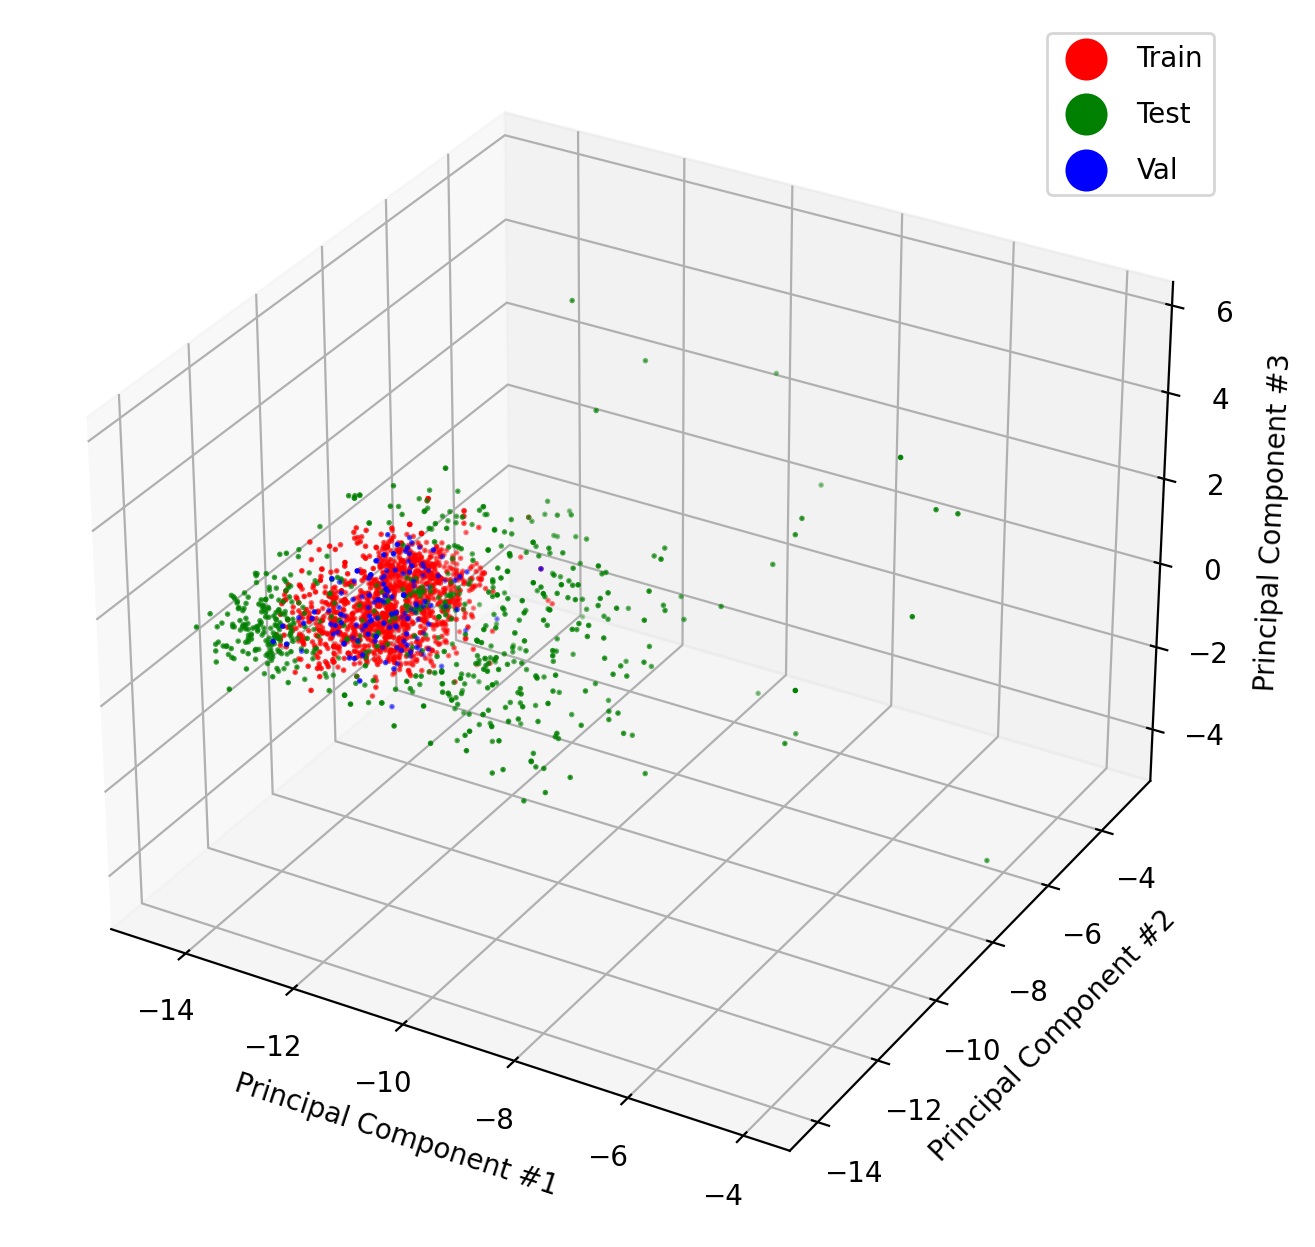

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [18]:
median = np.array([7, 7, 7, 8, 8, 8])

# Add a new column for L2 distance from Eulicidean mean and normalise. Return the original mean and sigma
df2, data_mean2, data_std2 = pre.process_df_euclid(df=df_orig.copy(), x_cols=x_cols, median=median)

component = 12           # Which column to sort by? This affects the splitting of validation data and visualisation later on
cutoff_percentile = (0.02,0.3)#0.2772 # How much to cut off the beginning and end of sorted dataset
val_split = 0.1          # How much to split off for validation (after the OoD/test data has been split off from train)

# Split training, testing and validation data
TRAIN, VAL, TEST = pre.split_data(df2, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

print(f"len(x_train): {len(x_train)}")
print(f"len(x_test): {len(x_test)}")
print(f"len(x_val): {len(x_val)}")
print(f"Total: {len(x_train) + len(x_test) + len(x_val)} of {len(df_orig)}")

# Get PCA of NORMALISED data, but according to UNNORMALISED PCA components
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], labels=["Train", "Test", "Val"], legend_num=0, figsize=(8,8),dpi=200)

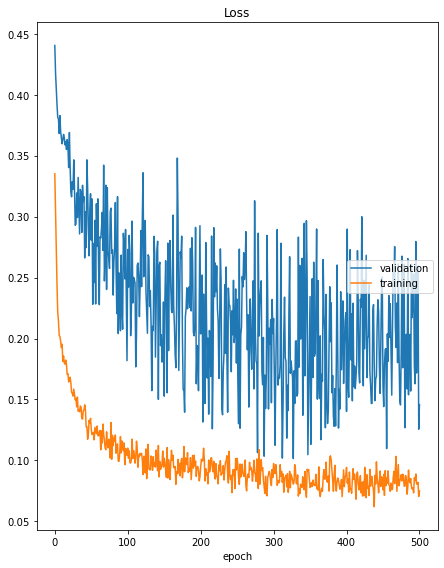

Loss
	validation       	 (min:    0.102, max:    0.440, cur:    0.146)
	training         	 (min:    0.062, max:    0.335, cur:    0.075)
Time elapsed: 19.23s.
Number of trainable model parameters: 191, number of training samples: 1220
Used batches of 50.



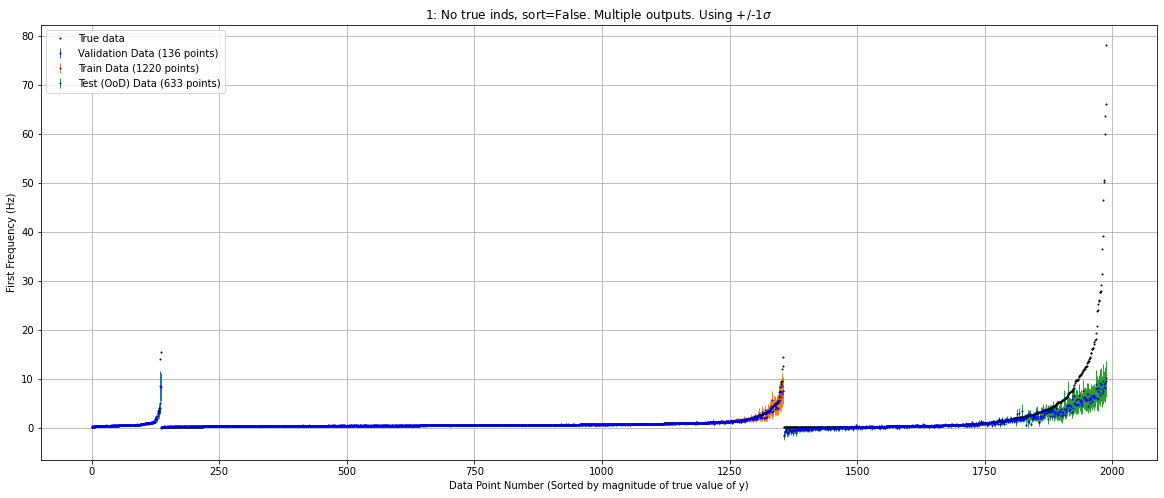

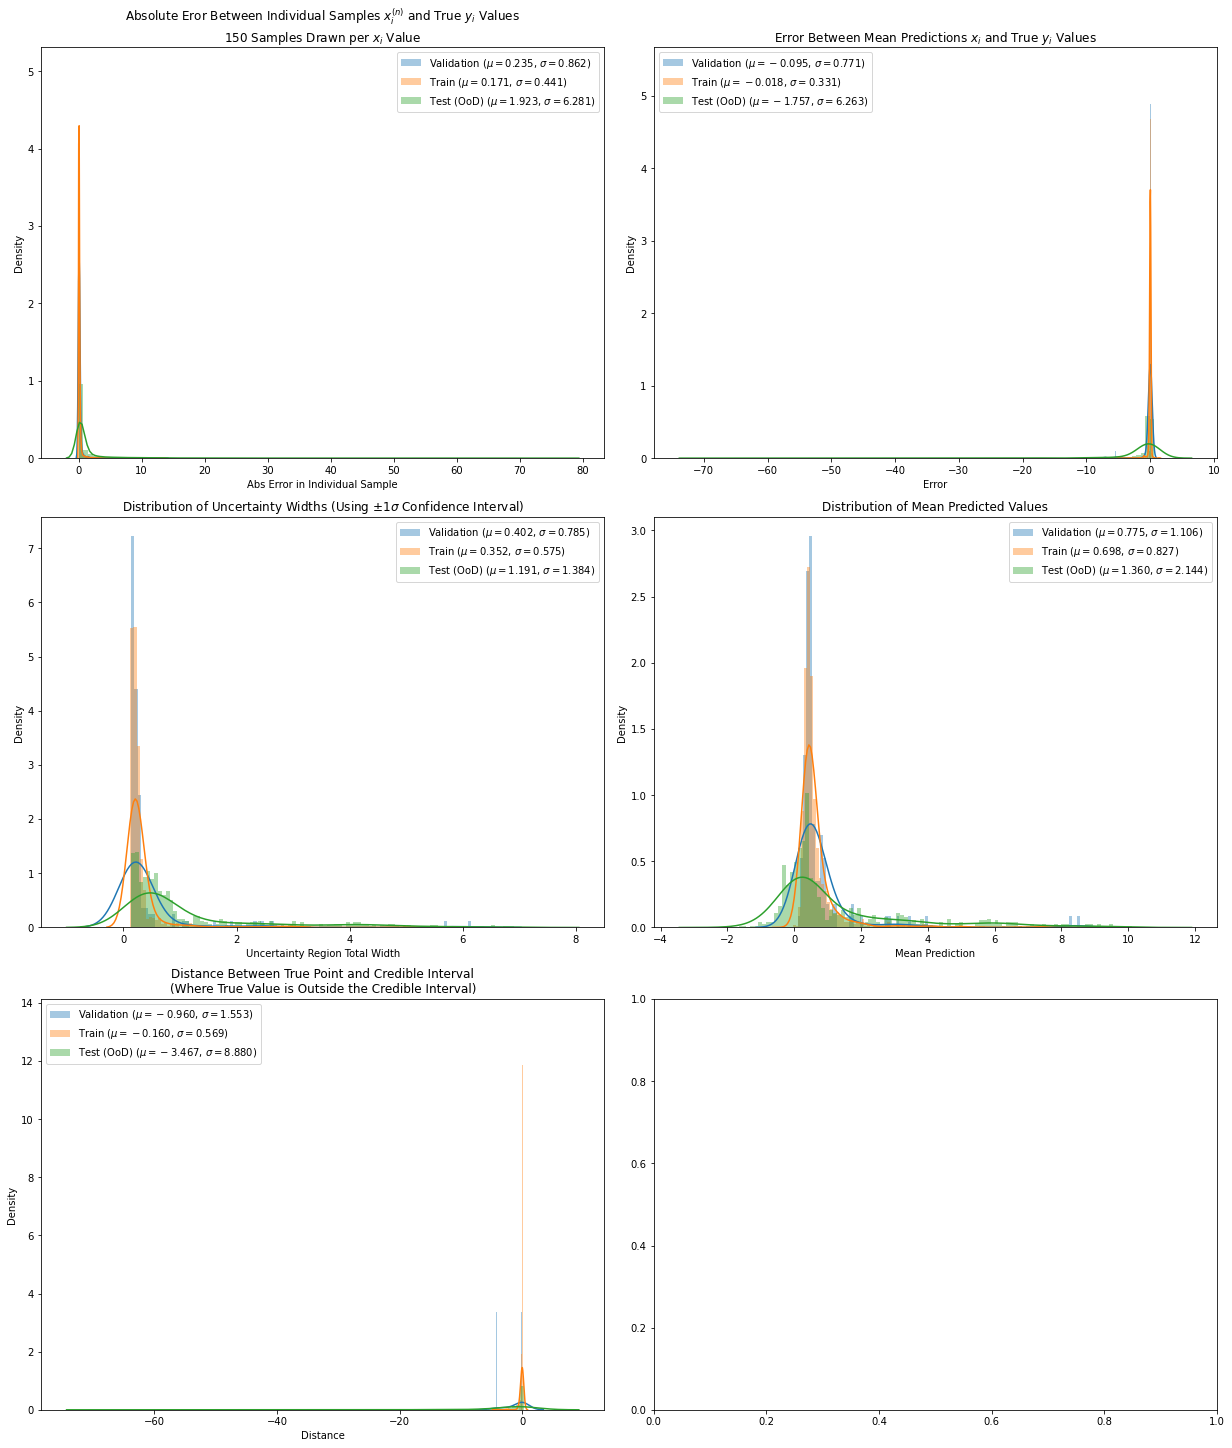

In [9]:
model = MC.MC_Dropout(train_data = train_data,
                      parameters=parameters,
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=False)
net, train_loss, val_loss = model.train_model(LLP=True)
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = "n/a",
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)")
             #ylim=(0,1.5))
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3, bins=100, figsize=(17,20))

## Split Data by Scale of y Value (freq1)

len(x_train): 1351
len(x_test): 495
len(x_val): 151
Total: 1997 of 1977


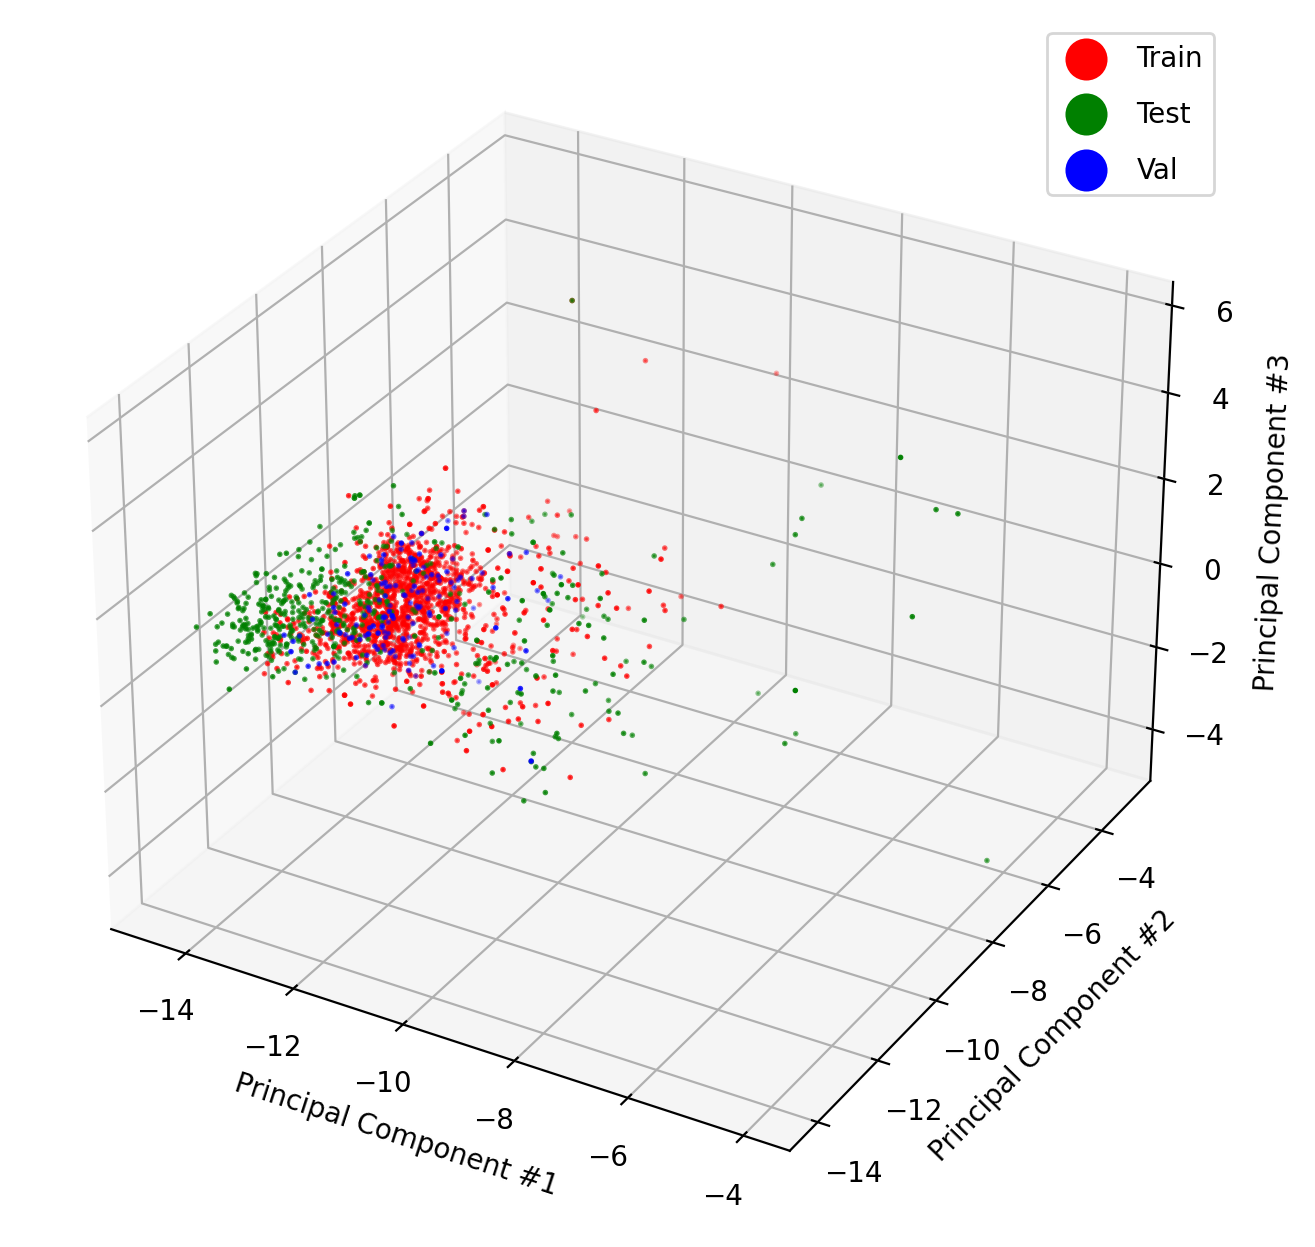

<Axes3DSubplot:xlabel='Principal Component #1', ylabel='Principal Component #2'>

In [19]:
# Add a new column for L2 distance from Eulicidean mean and normalise. Return the original mean and sigma
df3, data_mean3, data_std3 = pre.process_df_euclid(df=df_orig.copy(), x_cols=x_cols)

component = 6           # Which column to sort by? This affects the splitting of validation data and visualisation later on
cutoff_percentile = (0.05,0.2)#,0.28)# How much to cut off the beginning and end of sorted dataset
val_split = 0.1          # How much to split off for validation (after the OoD/test data has been split off from train)

# Split training, testing and validation data
TRAIN, VAL, TEST = pre.split_data(df3, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

print(f"len(x_train): {len(x_train)}")
print(f"len(x_test): {len(x_test)}")
print(f"len(x_val): {len(x_val)}")
print(f"Total: {len(x_train) + len(x_test) + len(x_val)} of {len(df_orig)}")

# Get PCA of NORMALISED data, but according to UNNORMALISED PCA components
x_train_PCA = post.PCA_transformdata(x_train, components=components)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)

post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], labels=["Train", "Test", "Val"], legend_num=0, figsize=(8,8),dpi=200)

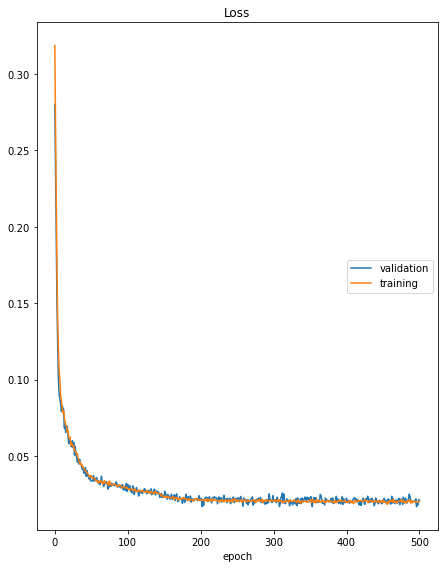

Loss
	validation       	 (min:    0.017, max:    0.280, cur:    0.021)
	training         	 (min:    0.018, max:    0.319, cur:    0.020)
Time elapsed: 20.14s.
Number of trainable model parameters: 191, number of training samples: 1351
Used batches of 50.



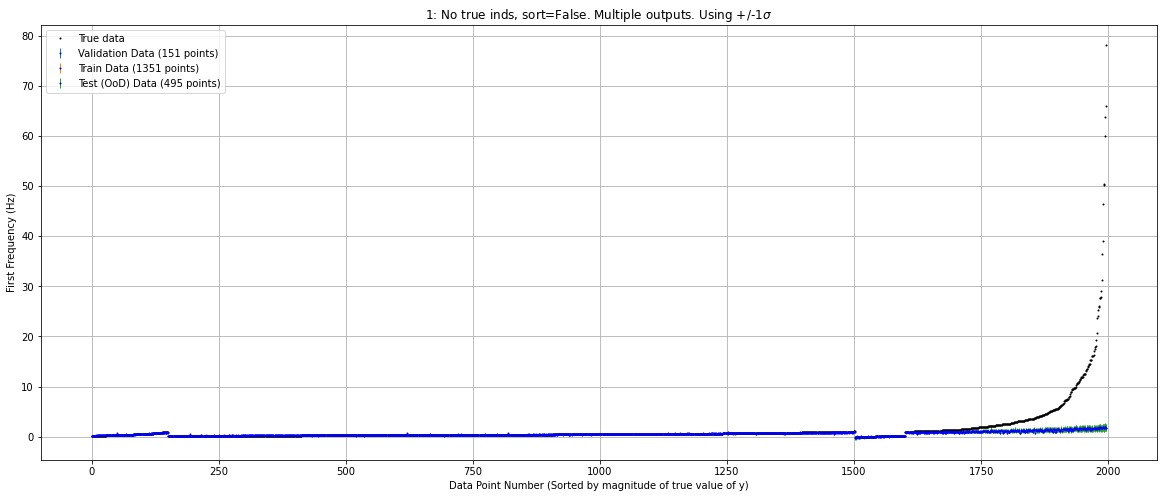

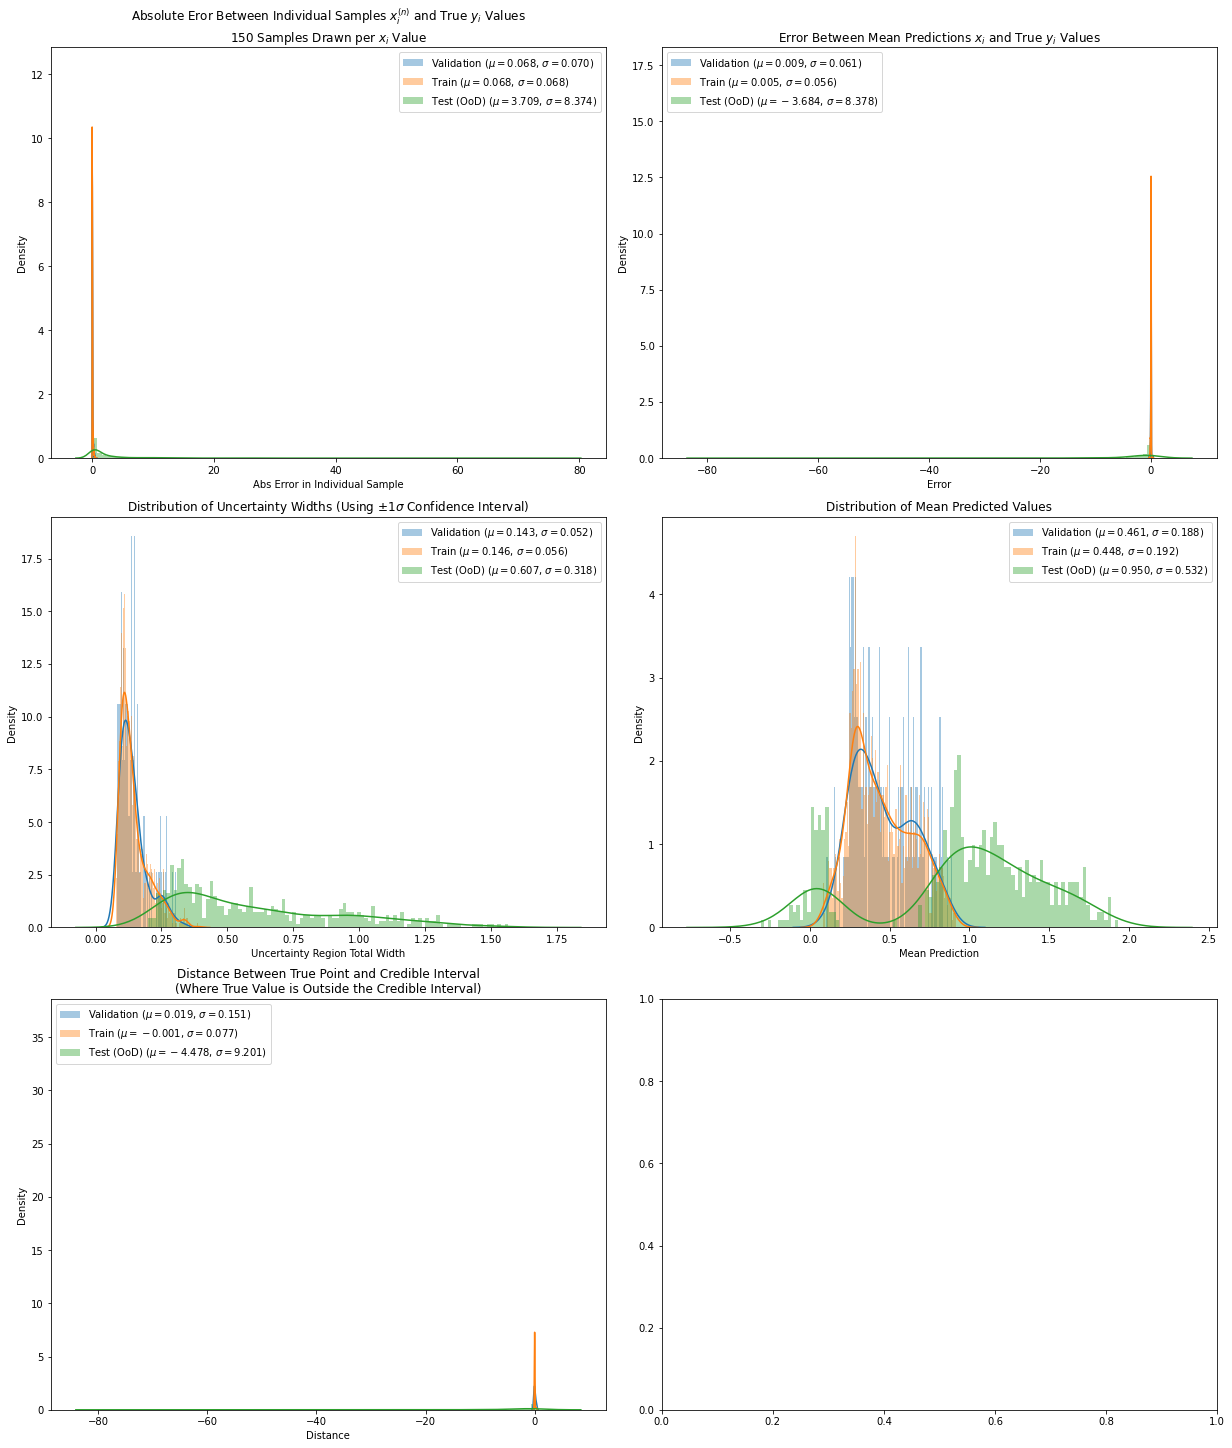

In [11]:
model = MC.MC_Dropout(train_data = train_data,
                      parameters=parameters,
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=False)
net, train_loss, val_loss = model.train_model(LLP=True)
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = "n/a",
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)")
             #ylim=(0,1.5))
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3, bins=100, figsize=(17,20))

## Splitting Data Using Manual Bounds on Data - Simple

Train:		929
Test:		944
Val:		104
Total:		1977 (of 1977)


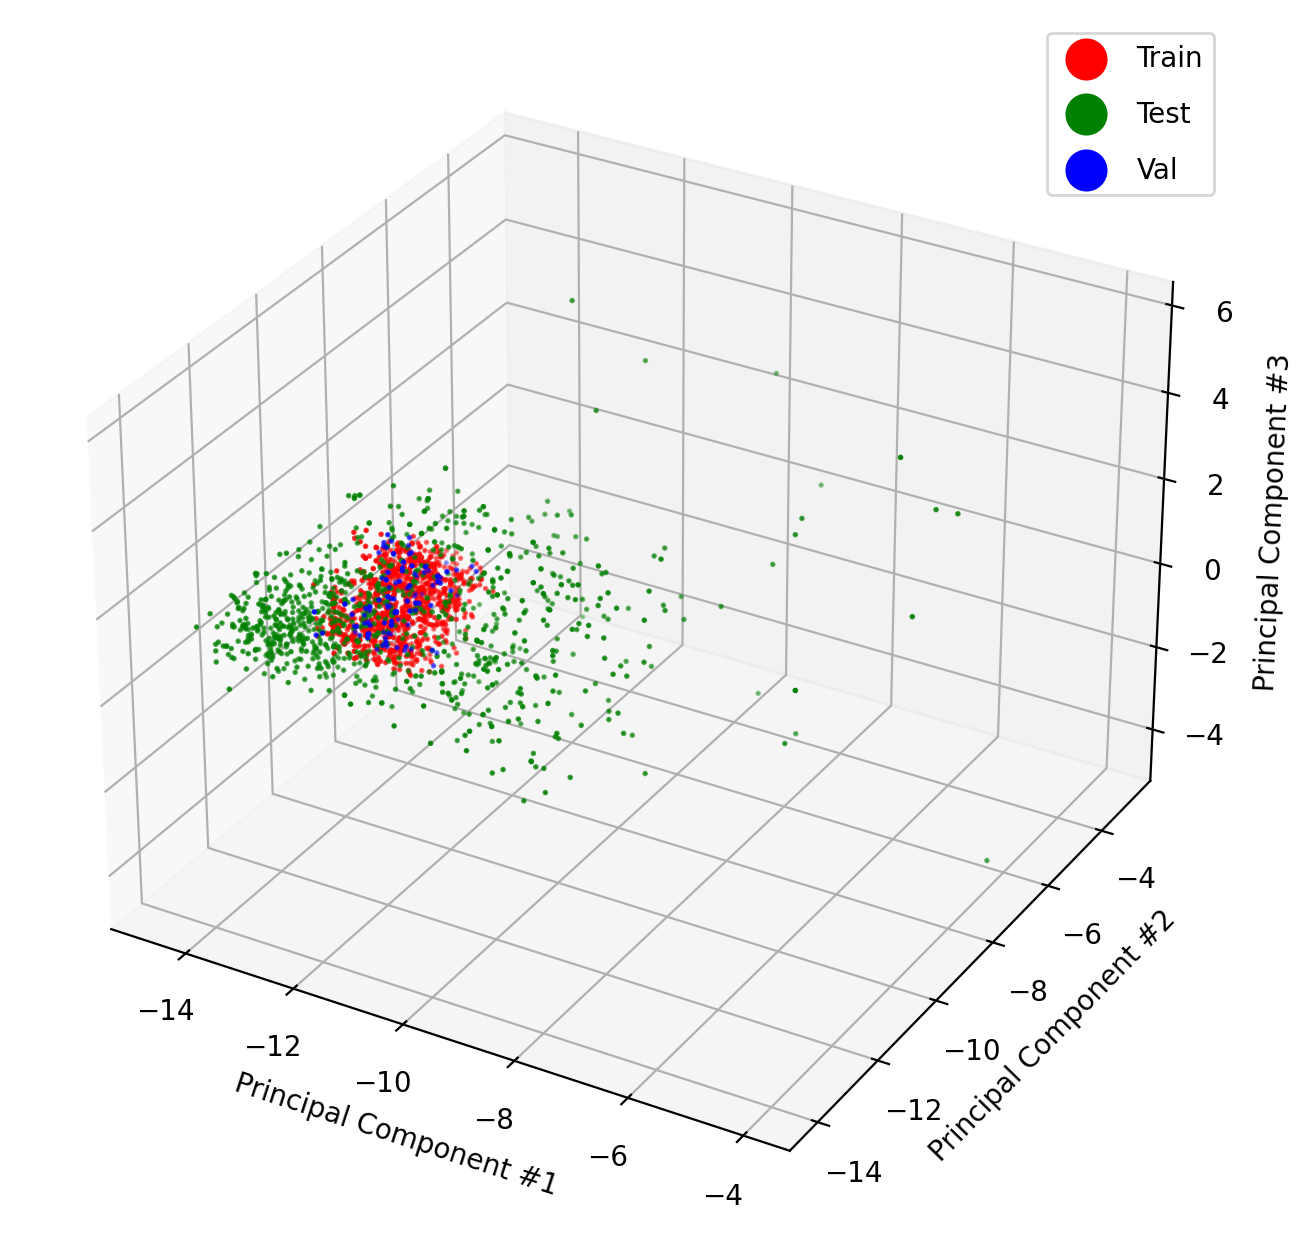

In [21]:
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]

TRAIN, VAL, TEST = pre.split_by_bounds(df=df_orig,
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 figsize=(8,8),
                                    plots=True,
                                 dpi=200)

x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

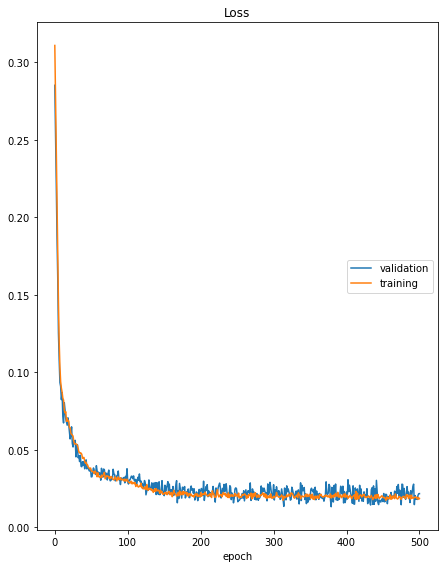

Loss
	validation       	 (min:    0.013, max:    0.285, cur:    0.022)
	training         	 (min:    0.017, max:    0.311, cur:    0.019)
Time elapsed: 13.77s.
Number of trainable model parameters: 191, number of training samples: 929
Used batches of 50.



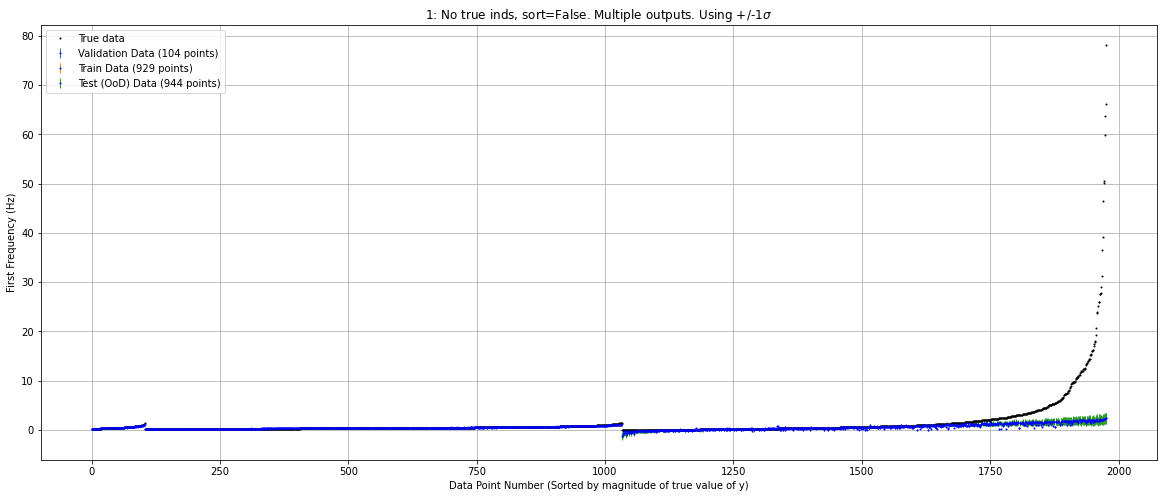

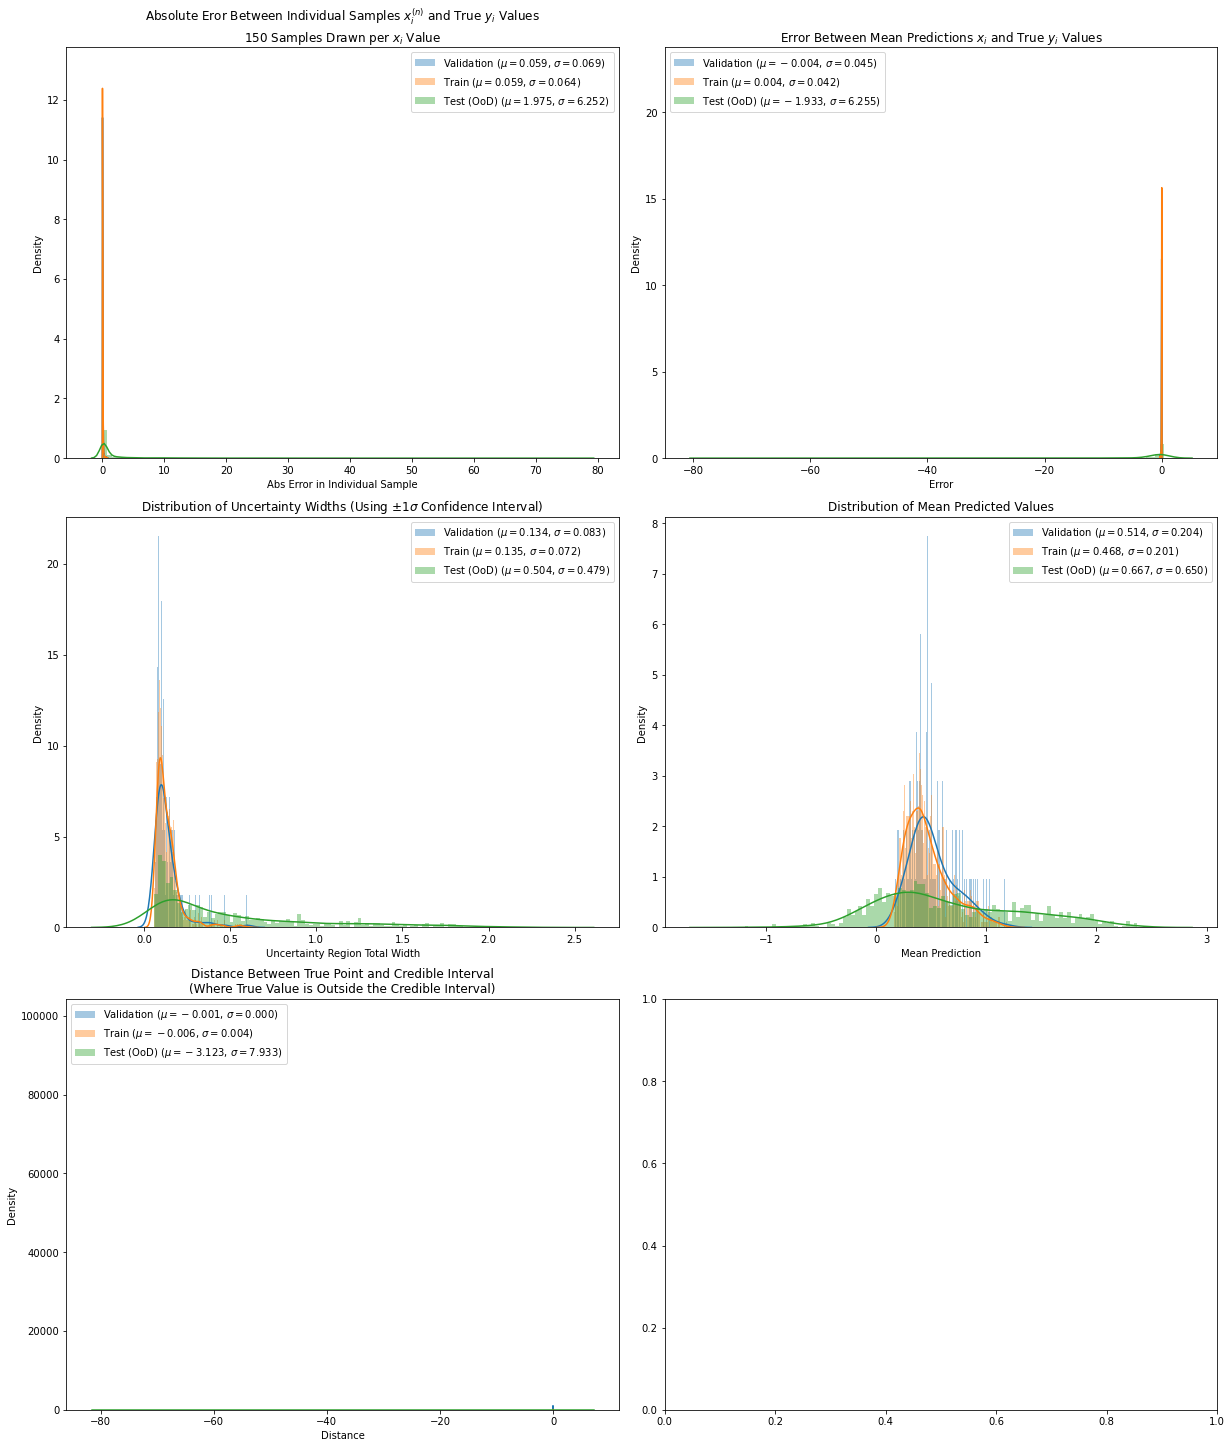

In [13]:
model = MC.MC_Dropout(train_data = train_data,
                      parameters=parameters,
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=False)
net, train_loss, val_loss = model.train_model(LLP=True)
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = "n/a",
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)")
             #ylim=(0,1.5))
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3, bins=100, figsize=(17,20))

## Splitting Data Using Manual Bounds on Data - More Complex

OOD lower:	834
OOD upper:	195
Train:		929
Test:		862
Val:		104
Unused:		82
Total:		1977 (of 1977)


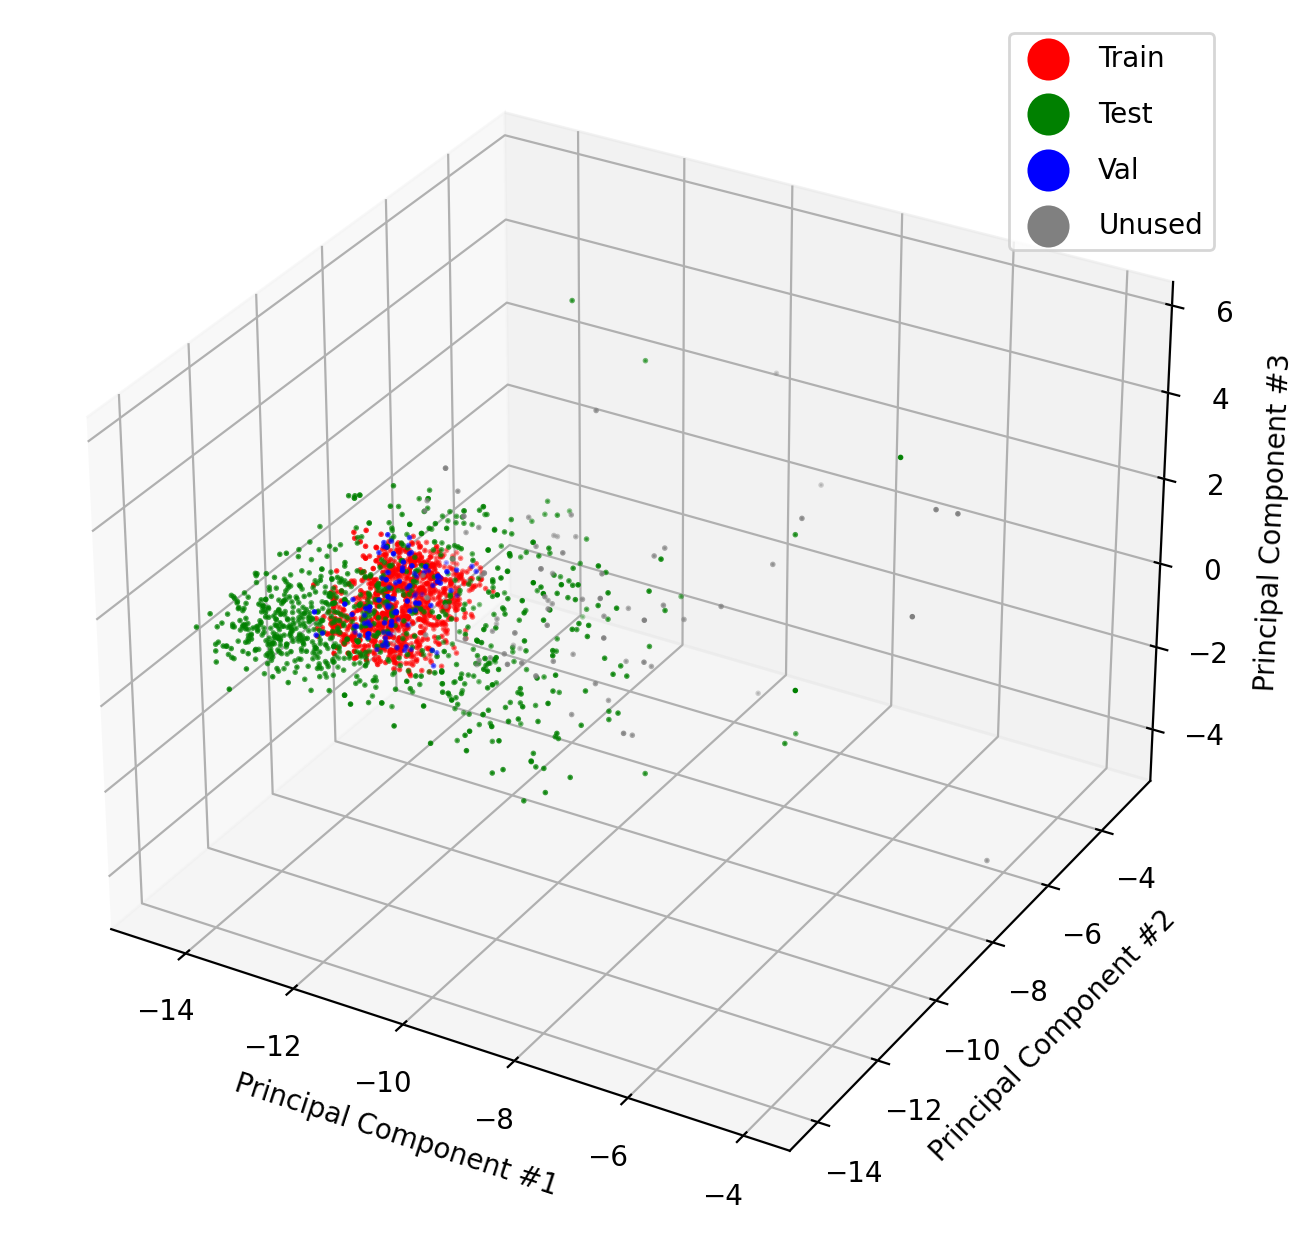

In [25]:
ood_lims_in = [[0., 3.], [0., 3.], [0., 3.], [0., 5.], [0., 5.], [0., 5.]]
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]
ood_lims_out = [[10, 25], [10, 25], [10, 30], [10, 12], [10, 12], [10, 12]]

TRAIN, VAL, TEST = pre.split_by_bounds(df=df_orig,
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all,
                                 ood_lims_in=ood_lims_in,
                                 ood_lims_out=ood_lims_out,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 plots=True,
                                 figsize=(8,8),
                                       dpi=200)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

y_train_unnorm = pre.unnormalise(y_train,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test,data_mean[y_cols].values,data_std[y_cols].values)


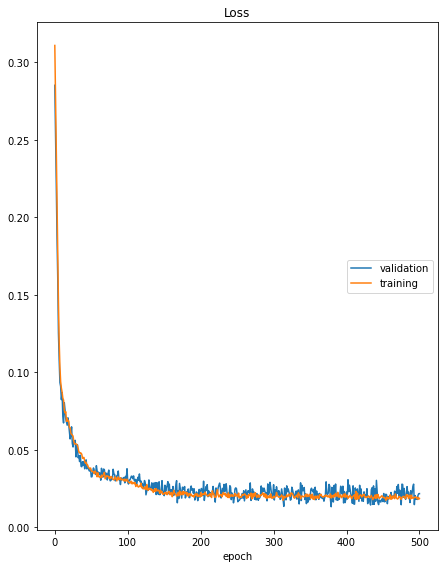

Loss
	validation       	 (min:    0.013, max:    0.285, cur:    0.022)
	training         	 (min:    0.017, max:    0.311, cur:    0.019)
Time elapsed: 17.96s.
Number of trainable model parameters: 191, number of training samples: 929
Used batches of 50.



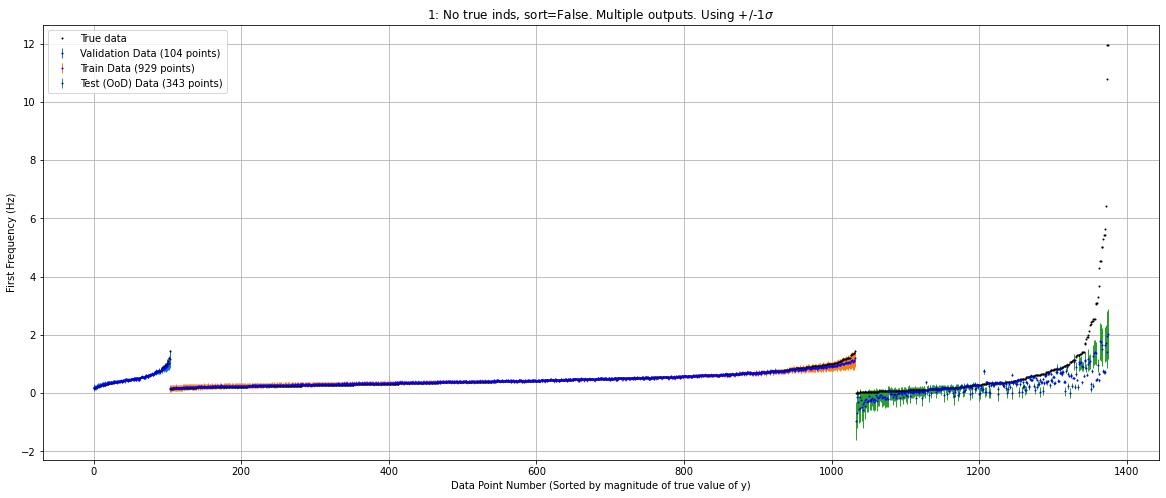

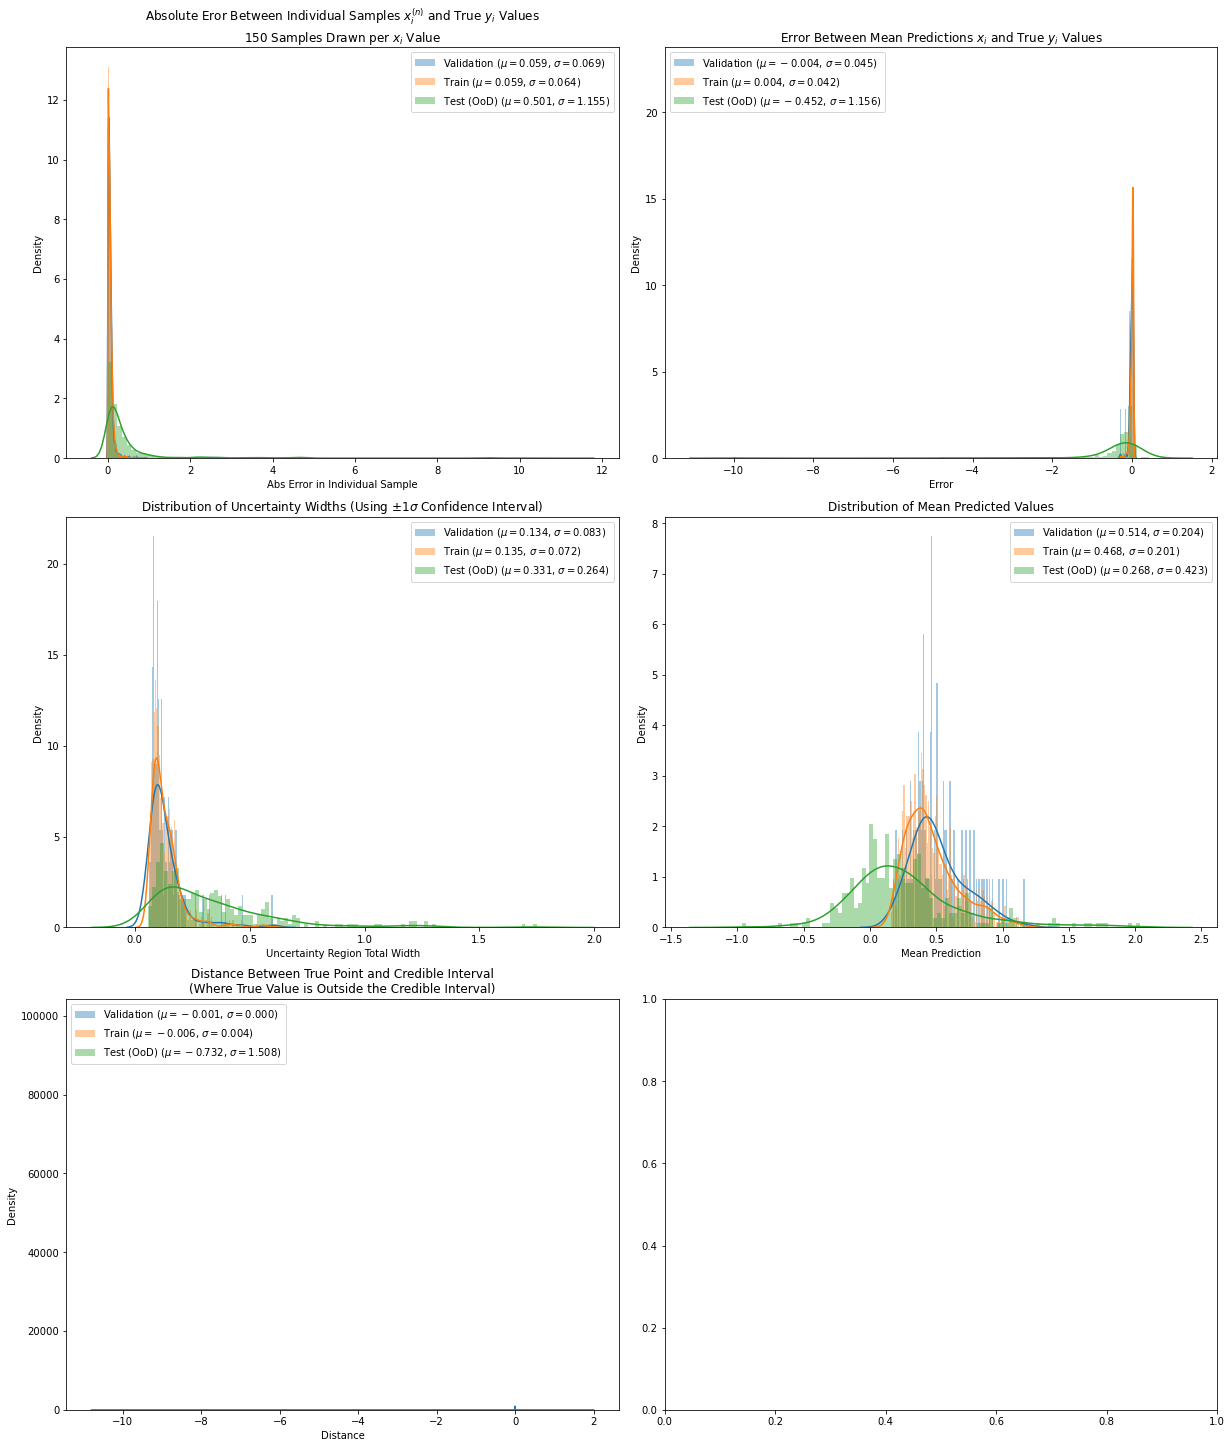

In [15]:
model = MC.MC_Dropout(train_data = train_data,
                      parameters=parameters,
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=False)
net, train_loss, val_loss = model.train_model(LLP=True)
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = "n/a",
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)")
             #ylim=(0,1.5))
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3, bins=100, figsize=(17,20))

## Separating by PCA Distance from Geometric Mean

len(x_train): 927
len(x_test): 946
len(x_val): 104
Total: 1977 of 1977


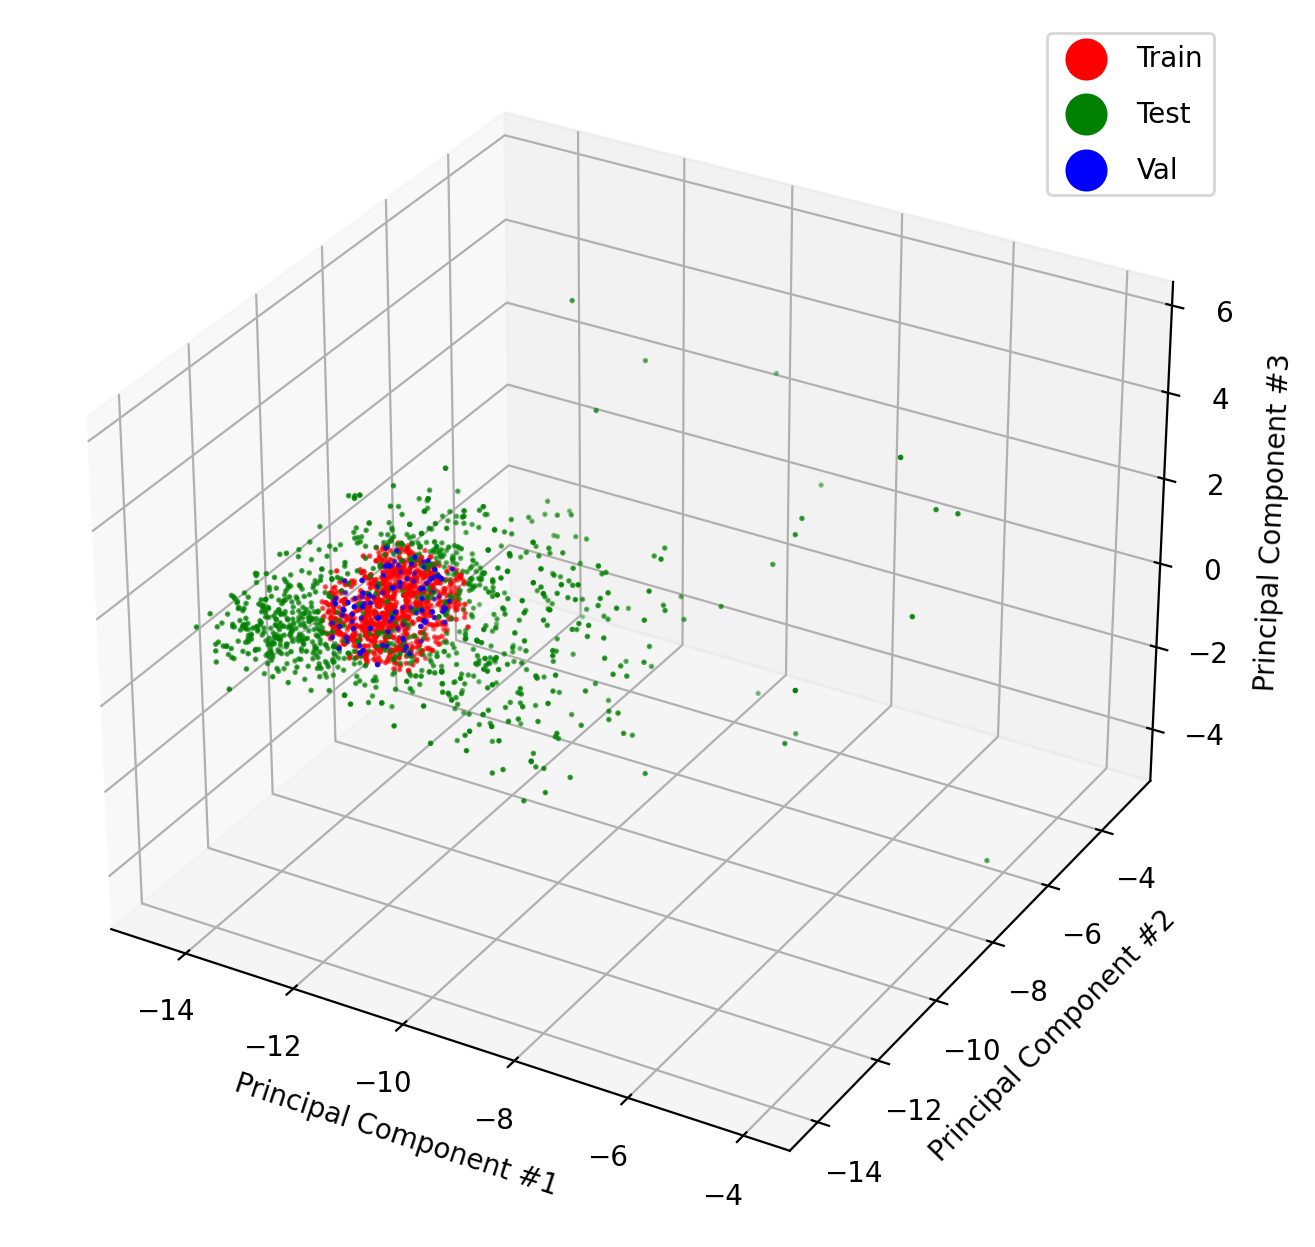

In [26]:
TRAIN, VAL, TEST = pre.split_by_PCA_mean(df=df_orig,
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 dist=1.2584,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 plots=True,
                                        dpi=200)

x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

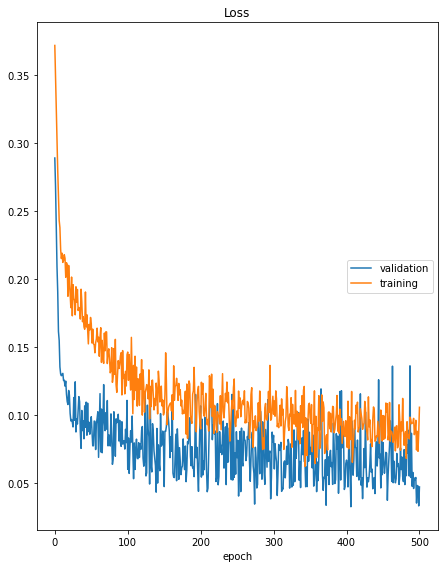

Loss
	validation       	 (min:    0.033, max:    0.289, cur:    0.047)
	training         	 (min:    0.062, max:    0.372, cur:    0.106)
Time elapsed: 9.95s.
Number of trainable model parameters: 191, number of training samples: 927
Used batches of 50.



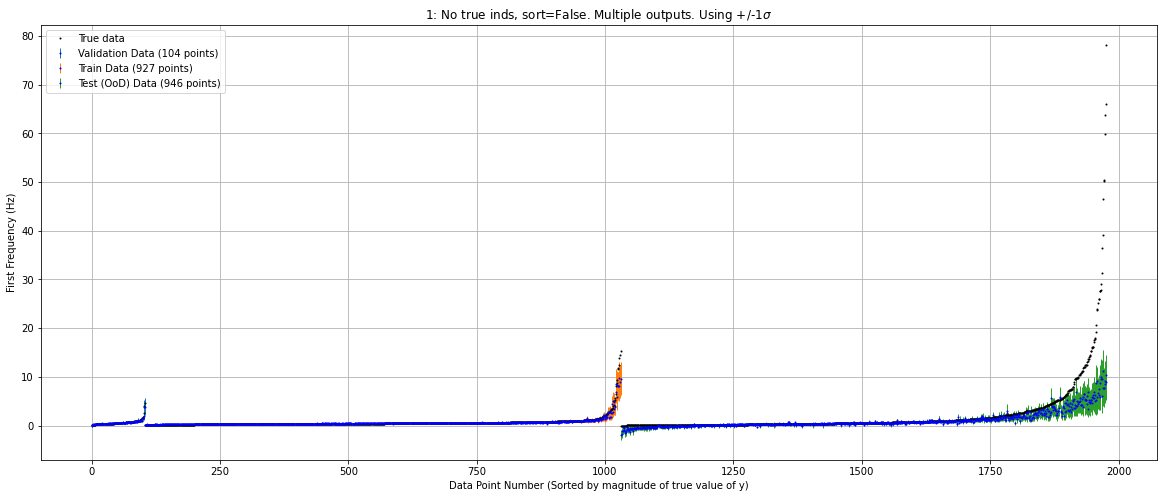

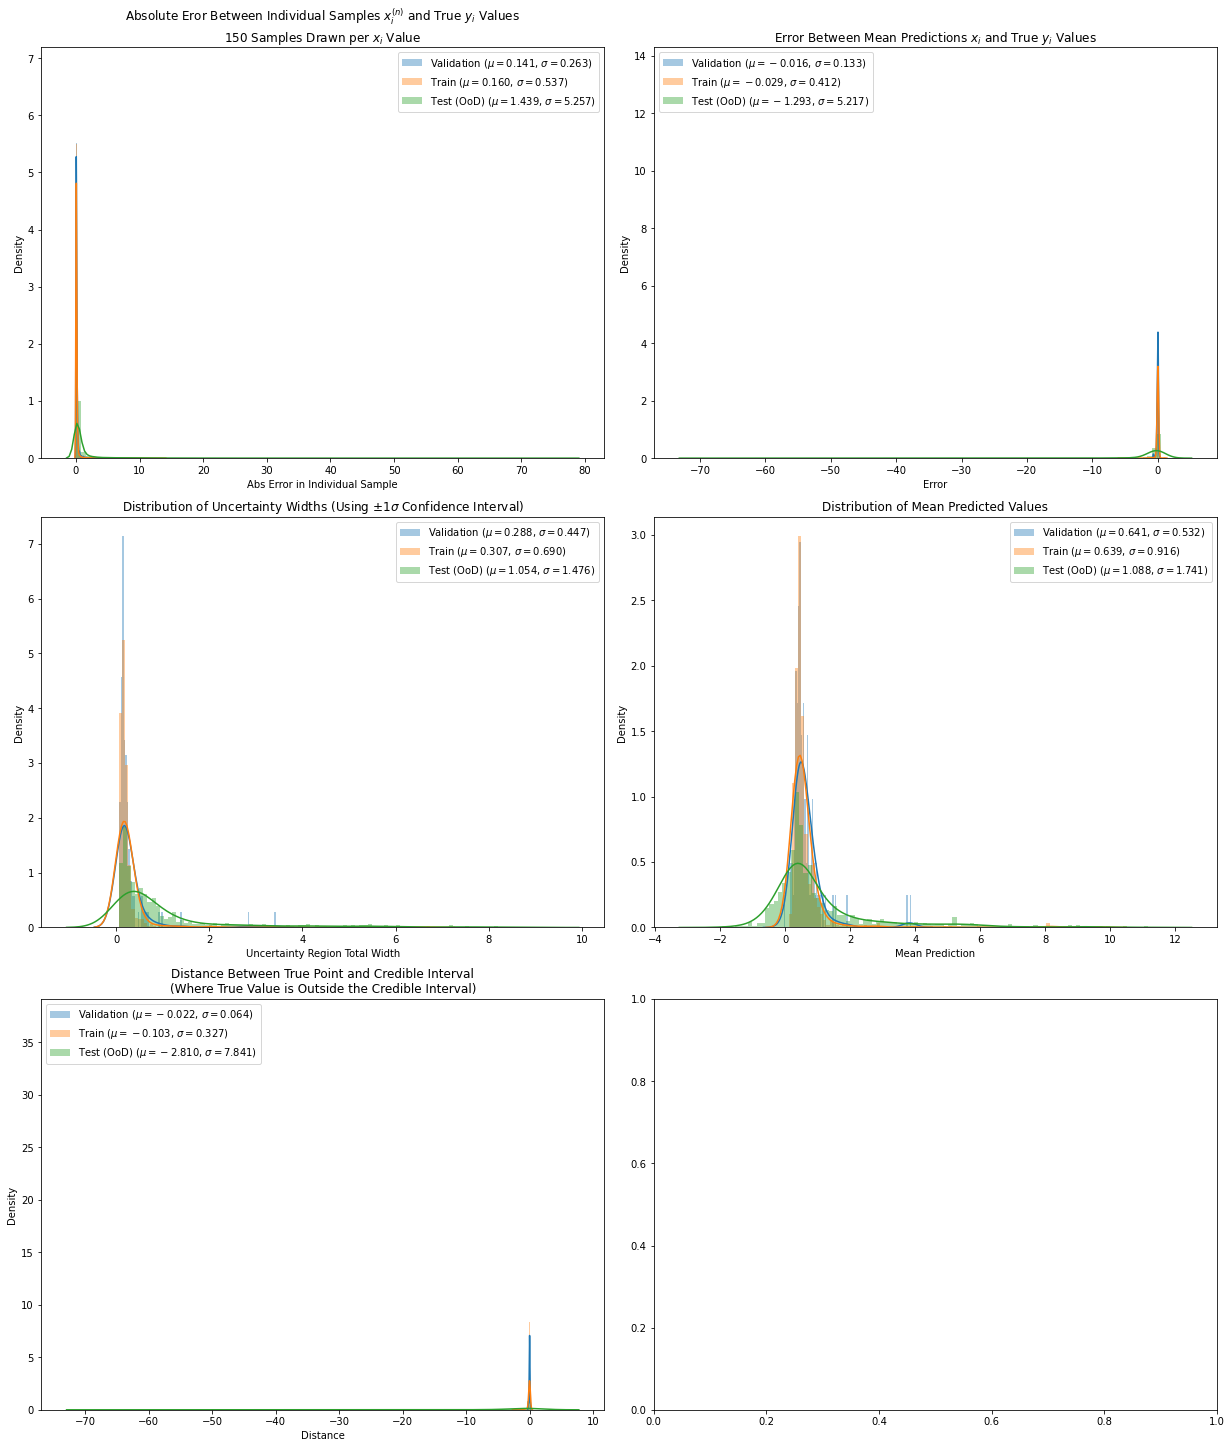

In [19]:
model = MC.MC_Dropout(train_data = train_data,
                      parameters=parameters,
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=False)
net, train_loss, val_loss = model.train_model(LLP=True)
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = "n/a",
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)")
             #ylim=(0,1.5))
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3, bins=100, figsize=(17,20))